# Residual U-Net Train

This notebook trains a residual U-Net model for enhanced JPEG reconstruction.

Details:
- On the fly data augmentation
- JPEG quality varying between 10-20
- Dropout

In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
from cs_models import deep_cascade_unet_no_dc

Using TensorFlow backend.


In [2]:
# Train and validation data paths
train_path = "../../TIFF/Development/Training/*.tif"
val_path = "../../TIFF/Development/Validation//*.tif"

# Listing train and validation images
train_images = glob.glob(train_path)
val_images = glob.glob(val_path)

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))

Train set size: 10740
Validation set size: 5370


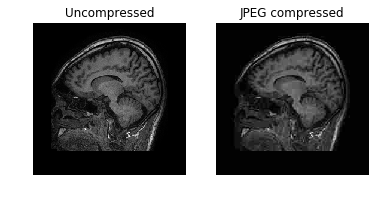

In [3]:
# Load uncompressed image
im1 = Image.open(train_images[100])
im1_array = np.array(im1)

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure()
plt.subplot(121)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(122)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [4]:
H,W = 256, 256
norm = 255.0
compr_range = (10,20)

train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)


# Train set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1)

    
# Validation set
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
val_compr = np.zeros((len(val_images),H,W,2),dtype = np.float32)
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1)/norm

    # JPEG compress the image    
    buffer = io.BytesIO()
    im1.save(buffer, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buffer)
    kspace_im2 = np.fft.fft2(np.array(im2)/norm)
    val_compr[ii,:,:,0] = kspace_im2.real
    val_compr[ii,:,:,1] = kspace_im2.imag

In [5]:
epochs = 30
batch_size= 8
model_name = "../Models/rwnet_data_augmentation_compress_10_20.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam()
model = deep_cascade_unet_no_dc()
model.compile(loss = "mse",optimizer=opt)

(8, 256, 256, 2)
(8, 256, 256, 1)
-3801.496445935915 9113.094117647059
0.0 0.87414694


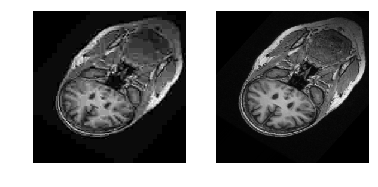

In [6]:
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

def combine_generator(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros((batch_unc.shape[0],batch_unc.shape[1],batch_unc.shape[2],2))
        compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               batch_unc.shape[0],replace = True)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            kspace_im2 = np.fft.fft2(np.array(im2)/255.0)
            batch_comp[ii,:,:,0] = kspace_im2.real
            batch_comp[ii,:,:,1] = kspace_im2.imag
        yield(batch_comp, batch_unc/255.0)

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,compr_range)


# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[1].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(np.abs(np.fft.ifft2(ii[0][2,:,:,0]+1j*ii[0][2,:,:,1])),cmap = 'gray')
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray')
    plt.axis("off")
    plt.show()
    break

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

Epoch 1/30
1343/1342 [==============================] - 281s 209ms/step - loss: 3.7144e-04 - val_loss: 5.8135e-04
Epoch 2/30
1343/1342 [==============================] - 257s 191ms/step - loss: 3.4819e-04 - val_loss: 5.6494e-04
Epoch 3/30
1343/1342 [==============================] - 257s 192ms/step - loss: 3.4121e-04 - val_loss: 5.6137e-04
Epoch 4/30
1343/1342 [==============================] - 257s 191ms/step - loss: 3.3572e-04 - val_loss: 5.5375e-04
Epoch 5/30
1343/1342 [==============================] - 256s 191ms/step - loss: 3.3271e-04 - val_loss: 5.5204e-04
Epoch 6/30
1343/1342 [==============================] - 256s 191ms/step - loss: 3.3015e-04 - val_loss: 5.4911e-04
Epoch 7/30
1343/1342 [==============================] - 258s 192ms/step - loss: 3.2721e-04 - val_loss: 5.4718e-04
Epoch 8/30
1343/1342 [==============================] - 256s 191ms/step - loss: 3.2568e-04 - val_loss: 5.4066e-04
Epoch 9/30
  90/1342 [=>............................] - ETA: 3:29 - loss: 3.2698e-04

In [ ]:
#Saving training history
np.save("../Data/loss_residual_unet_data_augmentation_compress_10_20.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_unet_data_augmentation_compress_10_20.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()